# Explore here

(After doing this project I look up at the solution and realize it uses MinMaxScaler instead of StandardScaler wich affects the results of the model)

Imports

In [231]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Perform a basic EDA, to check for duplicates, null values, standarize the variables and do a feature selection for the model.

Collect the data

In [232]:
all_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv")

all_data.shape

(1338, 7)

Check for duplicates and delete them if any.

In [233]:
all_data = all_data.drop_duplicates().reset_index(drop= True)
all_data.shape

(1337, 7)

There was one duplicate, now check for any null or empty values

In [234]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


There aren't any null or empty values

Now before standarizing the variables and create a new dataframe with them, we need to factorize the categorical ones

In [235]:
#Factorie the categorical variables
all_data["sex_fact"] = pd.factorize(all_data["sex"])[0]
all_data["smoker_fact"] = pd.factorize(all_data["smoker"])[0]
all_data["region_fact"] = pd.factorize(all_data["region"])[0]

#Save all the variables for the new dataframe
num_variables = ["age", "sex_fact", "bmi", "children", "smoker_fact", "region_fact", "charges"]

#Scale all the variables using StandarScaler since we do not have binary ones
#Create the scaler first
scaler = StandardScaler()

#Use the StandardScaler and create a new dataframe
scal_features = scaler.fit_transform(all_data[num_variables])
fact_data_scal = pd.DataFrame(scal_features, index = all_data.index, columns = num_variables)

fact_data_scal.head()

,age,sex_fact,bmi,children,smoker_fact,region_fact,charges
0,-1.440418,-1.009771,-0.453160,-0.909234,-1.969660,-1.343163,0.297857
1,-1.511647,0.990324,0.509422,-0.079442,0.507702,-0.438017,-0.954381
2,-0.799350,0.990324,0.383155,1.580143,0.507702,-0.438017,-0.729373
3,-0.443201,0.990324,-1.305052,-0.909234,0.507702,0.467128,0.719104
4,-0.514431,0.990324,-0.292456,-0.909234,0.507702,0.467128,-0.777499


Now that the new dataframe with the scaled data is created, we need to split into train and test.

X will be our independant variables and y our dependant one, which in this case would be "charges", the one we need to predict.

In [236]:
X = fact_data_scal.drop(["charges"], axis= 1) #Independant variables
y = fact_data_scal["charges"]#Dependant variable, our target

#Using train_test_split from Sklearn, divide the variables into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)#Random state set to 42 to replicate the shuffle everytime

Now that variables are divided we need to select the best features from the dataset. This time we need to use f_regression from selectkbest as it's the proper method to select the features in case of a linear regression problem. 

This score function computes the F-value between each feature and the target, where a high score indicates a strong relationship between the feature and target.

Since I don't know what value of K is optimal, I'm going to test it based on code I found on "https://www.analyticslane.com/2024/02/23/seleccion-del-valor-optimo-de-k-en-seleckbest-de-scikit-learn/". This will give us results on performance based on K value

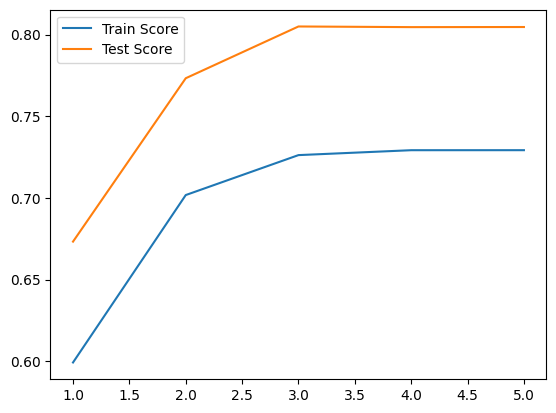

In [237]:

#List of possible values of K and performance
k_val = range(1, 6)
train_scores = []
test_scores = []

for k in k_val:
    #Using selectkbest with every k value and f_regression since it's a linear regression
    selection_model = SelectKBest(f_regression, k= k)
    X_train_sel = selection_model.fit_transform(X_train, y_train)

    #Train the linear regression model
    model = LinearRegression() #Create the model
    model.fit(X_train_sel, y_train)

    #Save the train score and test score on each iteration
    train_scores.append(model.score(X_train_sel, y_train))

    X_test_sel = selection_model.transform(X_test)
    test_scores.append(model.score(X_test_sel, y_test))

#Now we visualize the results to choose the best K
plt.plot(k_val, train_scores, label='Train Score')
plt.plot(k_val, test_scores, label='Test Score')
plt.legend()
plt.show()


We can observe that k= 4 is the best K for this case evenn though test score get's it's peak with k= 3, we focus on train. So we continue the feature selection with that number

In [238]:
#We create the selection model, in this case k is the number of features to be selected and f_regression the method used to determine wich are the best features to include
selection_model = SelectKBest(f_regression, k = 4)

#Fit the model with both X_train and y_train
selection_model.fit(X_train, y_train)

#Gets an array of the features selected
ix = selection_model.get_support()

#With ix we convert that array information into two new datasets that contain the features selected
X_train_features = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_features = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_features.head()

,age,bmi,children,smoker_fact
0,-1.155499,-1.009063,-0.909234,0.507702
1,-1.297958,-0.806543,0.750351,0.507702
2,0.910164,1.125178,0.750351,0.507702
3,1.693691,1.772092,-0.909234,0.507702
4,0.554015,-0.666338,0.750351,0.507702


Now save the data and continue with the exercise

In [239]:
#Add the target variable to the dataframes that contain the features selected previously
X_train_features["charges"] = list(y_train)
X_test_features["charges"] = list(y_test)

#Save the data
X_train_features.to_csv("../data/processed/clean_train.csv", index = False)
X_test_features.to_csv("../data/processed/clean_test.csv", index = False)


Now that the data is saved. The EDA is finished and continue with the Linear Regression part of the exercise.

In [240]:
#Read the data saved
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

#Divide into train and test for each independant and dependant variables
X_train = train_data.drop(["charges"], axis = 1) #Independant 
y_train = train_data["charges"] #Dependant

X_test = test_data.drop(["charges"], axis = 1) #Independant 
y_test = test_data["charges"] #Dependant

With the data loaded and divided, it's necessary to fit the model 

In [241]:
#Create the linear regression model
model = LinearRegression()

#Train the linear regression model
model.fit(X_train, y_train)

LinearRegression()

Now following the steps, we print the parameters fitted by the model.
- Intercept variable it's the value of the dependant variable (charges) when all the independant variables are zero.
- Coefficients are the ones that the model uses to get the value of Y, the target.

In [242]:
print(model.intercept_)
print(model.coef_)

-0.0074160838716888725
[ 0.28898608  0.1537753   0.05355447 -0.76832625]


Now using the test variables we test the model previously trained

In [243]:
y_pred = model.predict(X_test)

After this process, we calculate the MSE and the coefficient of determination, which means:
- Mean Squared Error or MSE: A metric to evaluate the effectiveness of the model, the lower the better
- Coefficient of determination or R2: This number shows how much data the model can explain the "charge" variable using the independant data. The higher the percentage the better the model fitting.

In [244]:

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.2450650135043426
0.8045531086669286


This model has a MSE of 0.2450650135043426 and a Coefficient of determination of 0.8045531086669286. This give us information that the model is correct, but we cannot optimize it using hyperparameters.
We need to use regularization techniques, ridge linear regression or lasso linear regression, but it's not the objective of this exercise.